In [1]:
from importlib import reload
import config
reload(config)
import os

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, loss, model, trainer
import numpy as np
import util

%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Github\smlm-dl\smlm_dl\dataset.py:364: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


1015:	 [id = 1015.000,], [A = 899.178,], [bg = 64.621,], [x = -2.071,], [y = -0.257,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
924:	 [id = 924.000,], [A = 1699.487,], [bg = 63.666,], [x = -10.344,], [y = 0.697,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
336:	 [id = 336.000,], [A = 1014.150,], [bg = 94.956,], [x = -2.772,], [y = 4.106,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
435:	 [id = 435.000,], [A = 1402.701,], [bg = 27.707,], [x = 10.579,], [y = 0.398,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
354:	 [id = 354.000,], [A = 1420.804,], [bg = 20.598,], [x = 6.032,], [y = 10.446,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
786:	 [id = 786.000,], [A = 1521.341,], [bg = 30.098,], [x = 5.759,], [y = 7.071,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
743:	 [id = 743.000,], [A = 1003.175,], [bg = 93.458,], [x = 8.059,], [y = 5.902,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
694:	 [id = 694.000,], [A = 1289.793,], [bg = 84.092,]

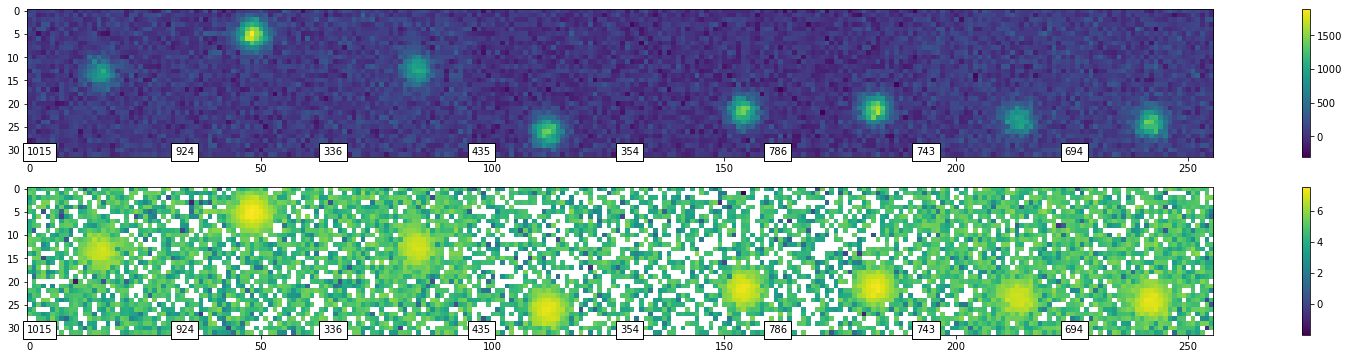

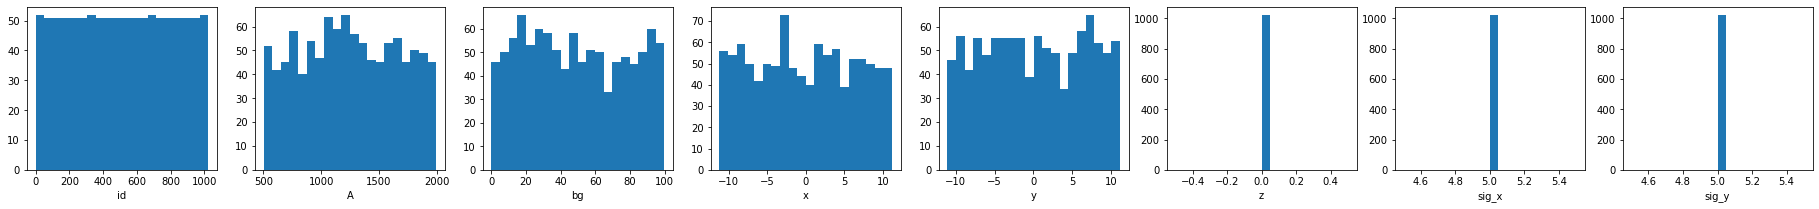

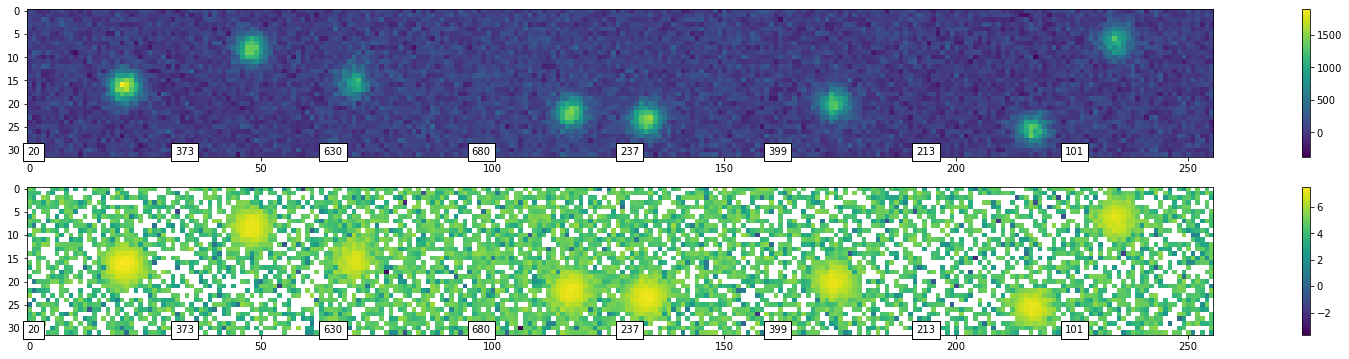

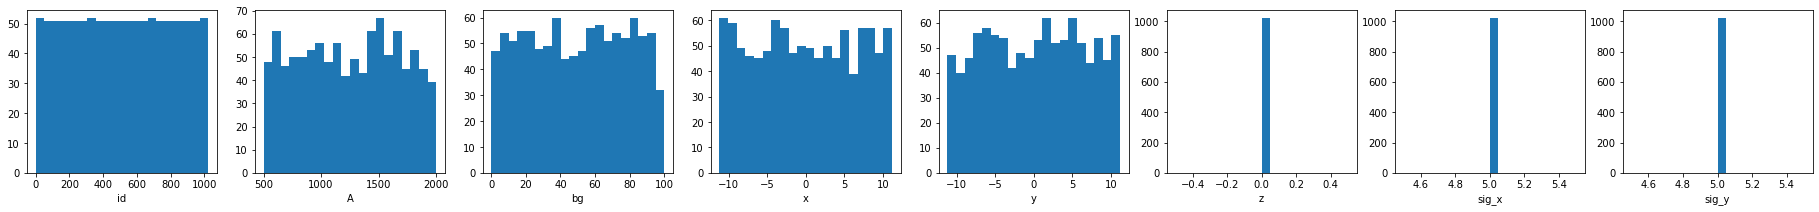

In [2]:
reload(dataset)

settings = {
    # 'out_size': (64,64),
    'length': (1024, 1),
    'dropout_p': 0,
    # 'psf_params': {'z':[-10,10]},
    # 'psf_params': {'A':[200, 500], 'bg':[0, 0]},
    # 'psf_zerns': psf_zerns,
    'noise_params': {'poisson': True, 'gaussian': 100},
    # 'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
    
}

training_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=512, shuffle=True)

valid_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=True)

['x', 'y', 'A', 'sig']


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [128, 4, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─Conv2d (0)                   [128, 16, 32, 32]         160
│    │    │    └─GELU (1)                     [128, 16, 32, 32]         --
│    │    │    └─Conv2d (2)                   [128, 16, 32, 32]         2,320
│    │    │    └─GELU (3)                     [128, 16, 32, 32]         --
│    │    │    └─MaxPool2d (4)                [128, 16, 16, 16]         --
│    │    │    └─Dropout2d (5)                [128, 16, 16, 16]         --
│    │    └─Sequential (conv_layer1)          [128, 32, 8, 8]           --
│    │    │    └─Conv2d (0)                   [128, 32, 16, 16]         4,640
│    │    │  

D:\Github\smlm-dl\smlm_dl\model\base.py:145: RuntimeWarning: divide by zero encountered in log10
  im = axes[0, i].imshow(np.log10(img))


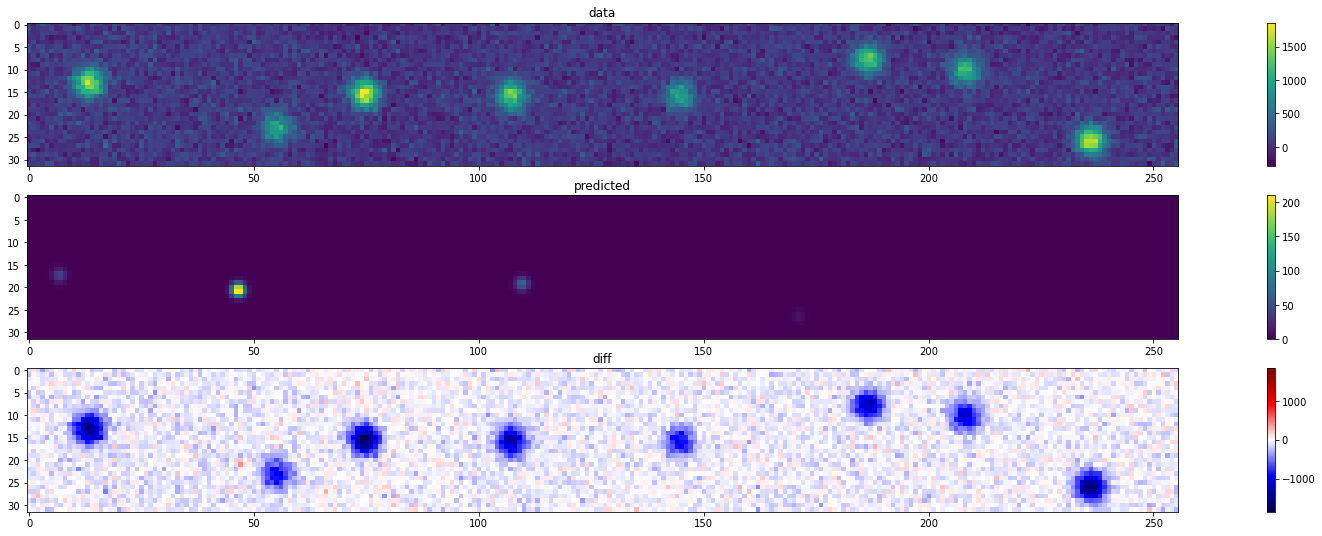

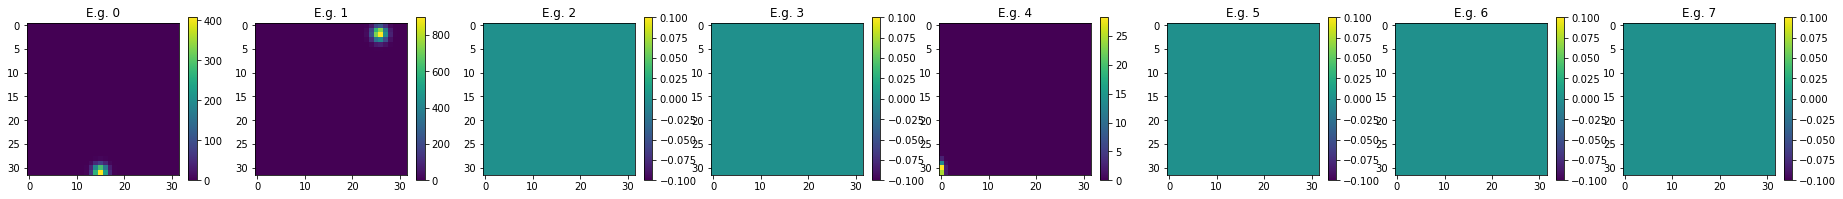

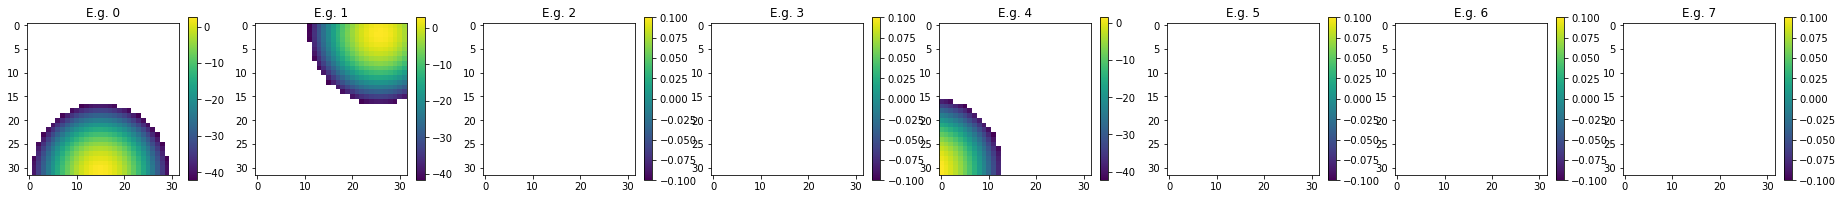

In [3]:
reload(model)

fitting_model = model.Gaussian2DModel(
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','sig',],
                                      max_psf_count=1,
                                      encoder_params={
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

print(fitting_model.fit_params)


print(summary(fitting_model, input_size=(128,1,32,32), row_settings=["var_names"], depth=4))

model.check_model(fitting_model, train_dataloader)

In [4]:
reload(loss)

<module 'loss' from 'D:\\Github\\smlm-dl\\smlm_dl\\loss.py'>

In [5]:
loss_func = loss.GaussMLECameraLoss(gain=1, offset=0, var=100*2)

training = trainer.FittingTrainer(fitting_model, train_dataloader, None, loss_function=loss_func)
training.train_and_validate(2, 10, 100)

No validation data supplied. Remember to set prior to training.
CUDA not available. Defaulting to CPU
Device: cpu
Saved to : D:\Pytorch\runs\2022-03-22_19-01-31_DESKTOP-7NNT713\model.ptm


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : D:\Pytorch\runs\2022-03-22_19-01-31_DESKTOP-7NNT713\checkpoint.ptc
model_state_dict: odict_keys(['encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.neck.conv_layer_0.4.bias', 'encoder.neck.conv_layer_1.0.weight', 'encoder.neck.conv_layer_1.0.bias', 'encoder.neck.conv_layer_1.1.weight', 'enc

In [6]:
loss_func = loss.GaussPoissonMLECameraLoss(gain=1, offset=0, var=100**2, debug=True)
optim_func = torch.optim.AdamW(fitting_model.parameters(), lr=1e-4)

# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, loss_function=loss_func)
training = trainer.FittingTrainer(fitting_model, train_dataloader, None, optimizer=optim_func, loss_function=loss_func)
training.train_and_validate(2, 10, 100)

No validation data supplied. Remember to set prior to training.
CUDA not available. Defaulting to CPU
Device: cpu
Saved to : D:\Pytorch\runs\2022-03-22_19-01-42_DESKTOP-7NNT713\model.ptm


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(4.6226, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(-18.6584, grad_fn=<SubBackward0>) tensor(-18.6584)
p tensor(-0., grad_fn=<DivBackward0>)
1
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(4.6226, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(-18.6584, grad_fn=<SubBackward0>) tensor(-18.6584, grad_fn=<SelectBackward0>)
p tensor(-0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(4.6726, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(-36.7309, grad_fn=<SubBackward0>) tensor(-36.7309)
p tensor(-0., grad_fn=<DivBackward0>)
1
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0.,

dict_keys(['poisson_nll_a', 'poisson_nll_b', 'gaussian_nll_a', 'gaussian_nll_b', 'input', 'target', 'poisson_noise', 'gaussian_noise', 'nll'])


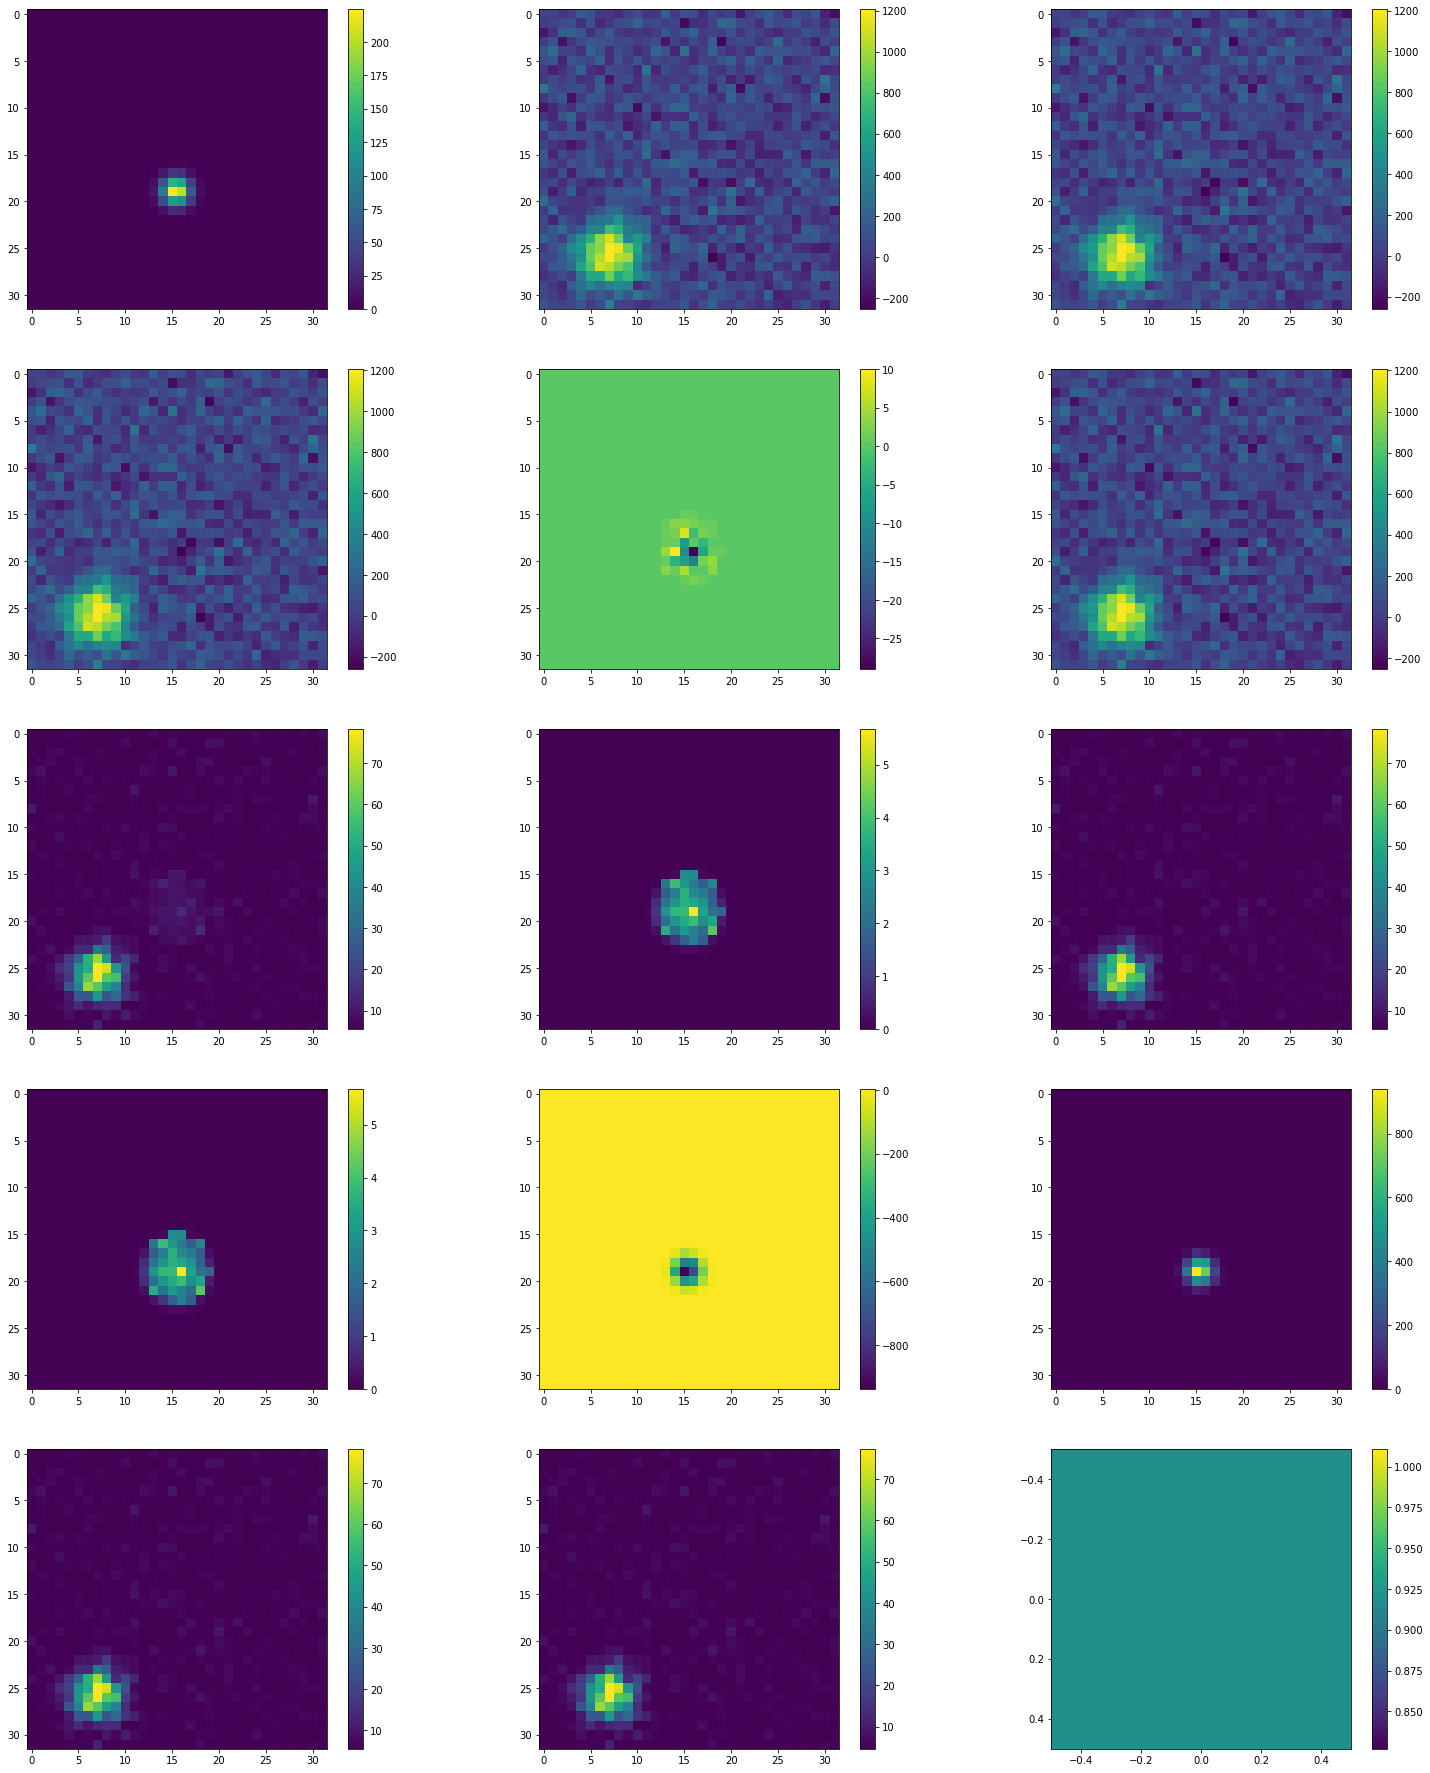

In [7]:
print(training.loss_function.cached_images.keys())
fig, axes = subplots(5, 3, figsize=(26,32))

im = axes[0,0].imshow(training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,0])
im = axes[0,1].imshow(training.loss_function.cached_images["target"][0,0])
colorbar(im, ax=axes[0,1])
im = axes[0,2].imshow(training.loss_function.cached_images["target"][0,0] - training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,2])

im = axes[1,0].imshow(training.loss_function.cached_images["poisson_noise"][0,0] + training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,0])
im = axes[1,1].imshow(training.loss_function.cached_images["poisson_noise"][0,0])
colorbar(im, ax=axes[1,1])
im = axes[1,2].imshow(training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,2])

im = axes[2,0].imshow(training.loss_function.cached_images["nll"][0,0])
colorbar(im, ax=axes[2,0])
im = axes[2,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[2,1])
im = axes[2,2].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[2,2])

im = axes[3,0].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,0])
im = axes[3,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0])
colorbar(im, ax=axes[3,1])
im = axes[3,2].imshow(training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,2])

im = axes[4,0].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[4,0])
im = axes[4,1].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0])
colorbar(im, ax=axes[4,1])
im = axes[4,2].imshow(training.loss_function.cached_images["gaussian_nll_b"][None,None])
colorbar(im, ax=axes[4,2])